# Summary of Broadcast between Nodes

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('display.max_columns', 30)


project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }
    nnodes = [2, 4, 8, 16, 32]

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            for nnode in nnodes:
                column_key = f'{method}:{node}:{nnode}'
                file_pattern = f'{dirpath}/job{nnode:02d}.sh.*.{suffix}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, legend_fontsize=None):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode:2,mpi-gpu:anode:4,mpi-gpu:anode:8,mpi-gpu:anode:16,mpi-gpu:vnode:2,mpi-gpu:vnode:4,mpi-gpu:vnode:8,mpi-gpu:vnode:16,mpi-gpu:vnode:32,mpi-cpu:anode:2,mpi-cpu:anode:4,mpi-cpu:anode:8,mpi-cpu:anode:16,mpi-cpu:vnode:2,mpi-cpu:vnode:4,mpi-cpu:vnode:8,mpi-cpu:vnode:16,mpi-cpu:vnode:32,nccl:anode:2,nccl:anode:4,nccl:anode:8,nccl:anode:16,nccl:vnode:2,nccl:vnode:4,nccl:vnode:8,nccl:vnode:16,nccl:vnode:32
1,8.52,11.12,14.22,16.61,6.16,7.95,9.64,12.29,13.90,2.43,3.57,6.12,7.18,1.76,2.72,3.46,5.22,6.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.97,14.51,17.72,20.01,7.95,9.81,11.59,14.50,15.59,2.44,3.60,5.99,7.07,1.76,2.72,3.54,5.08,6.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12.02,14.52,17.66,20.03,7.96,9.76,11.48,13.93,15.68,2.43,3.56,6.02,7.06,1.79,2.70,3.54,5.16,6.19,7.67,8.30,10.59,14.01,5.25,5.36,9.11,5.41,5.32
8,11.95,14.52,17.69,20.00,7.94,9.80,11.56,13.91,15.95,2.40,3.55,6.02,7.10,1.74,2.75,3.48,5.21,5.96,7.54,7.51,7.75,7.16,5.14,5.27,5.13,5.33,5.16
16,8.58,11.03,14.28,17.67,6.80,8.69,10.35,12.75,14.55,2.43,3.55,6.01,7.23,1.76,2.62,3.50,5.13,6.16,7.53,7.53,7.70,7.13,5.14,5.27,5.15,5.36,5.15
32,11.69,13.66,17.48,19.74,6.95,8.79,10.46,13.43,14.55,2.79,3.97,6.32,7.37,1.99,2.99,3.79,5.29,6.30,7.64,7.58,7.73,7.17,5.15,5.29,5.17,5.29,5.18
64,12.59,14.11,17.90,21.53,7.42,9.71,11.27,15.12,16.29,3.04,4.10,6.99,7.96,2.20,3.24,4.26,5.84,6.89,7.66,7.62,7.79,7.18,5.17,5.28,5.18,5.35,5.22
128,12.88,14.56,18.46,21.81,8.38,11.11,12.75,15.46,16.96,3.15,4.60,7.77,8.43,2.45,3.51,4.59,6.06,7.04,7.72,7.68,7.75,7.22,5.22,5.30,5.19,5.32,5.22
256,13.03,14.84,18.31,22.10,8.68,11.41,13.05,15.90,16.40,3.43,5.00,8.25,9.17,2.72,4.19,5.44,7.28,8.57,7.78,7.73,7.77,7.10,5.19,5.33,5.23,5.34,5.25
512,13.32,15.13,19.27,21.69,9.98,13.45,14.31,18.37,18.57,3.66,5.33,8.81,9.49,2.87,4.27,5.64,7.52,8.91,7.74,7.71,7.79,7.16,5.24,5.38,5.24,5.32,5.27


## Node(A) vs. Node(V)

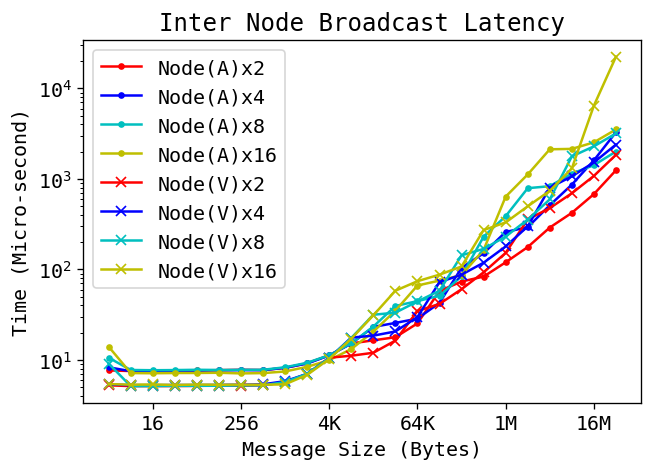

In [4]:
title = 'Inter Node Broadcast Latency'
column_labels = {
    'nccl:anode:2': 'Node(A)x2',
    'nccl:anode:4': 'Node(A)x4',
    'nccl:anode:8': 'Node(A)x8',
    'nccl:anode:16': 'Node(A)x16',
    'nccl:vnode:2': 'Node(V)x2',
    'nccl:vnode:4': 'Node(V)x4',
    'nccl:vnode:8': 'Node(V)x8',
    'nccl:vnode:16': 'Node(V)x16',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

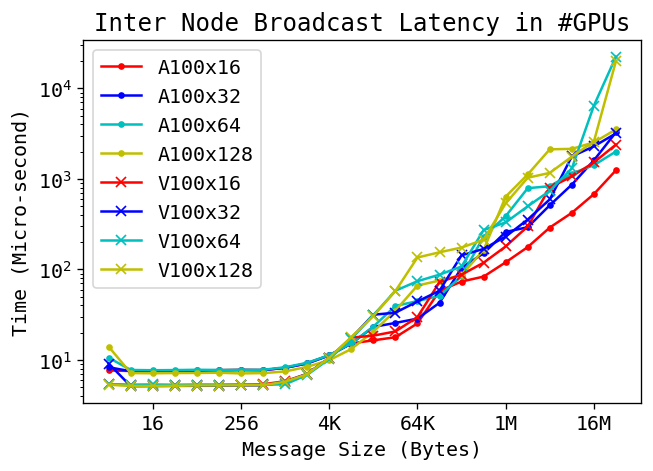

In [5]:
title = 'Inter Node Broadcast Latency in #GPUs'
column_labels = {
    'nccl:anode:2': 'A100x16',
    'nccl:anode:4': 'A100x32',
    'nccl:anode:8': 'A100x64',
    'nccl:anode:16': 'A100x128',
    'nccl:vnode:4': 'V100x16',
    'nccl:vnode:8': 'V100x32',
    'nccl:vnode:16': 'V100x64',
    'nccl:vnode:32': 'V100x128',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(A)

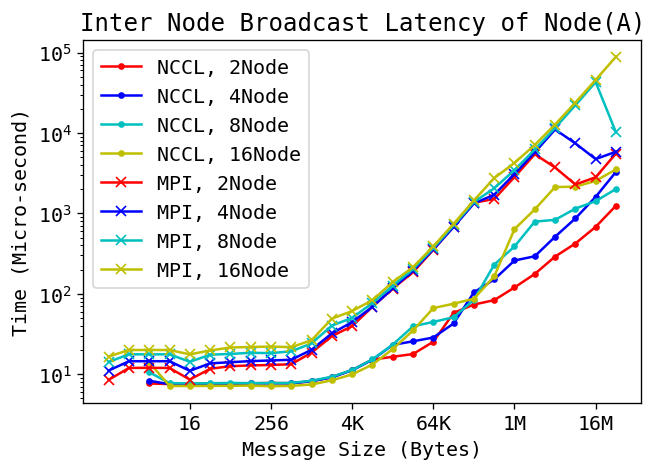

In [6]:
title = 'Inter Node Broadcast Latency of Node(A)'
column_labels = {
    'nccl:anode:2': 'NCCL, 2Node',
    'nccl:anode:4': 'NCCL, 4Node',
    'nccl:anode:8': 'NCCL, 8Node',
    'nccl:anode:16': 'NCCL, 16Node',
    'mpi-gpu:anode:2': 'MPI, 2Node',
    'mpi-gpu:anode:4': 'MPI, 4Node',
    'mpi-gpu:anode:8': 'MPI, 8Node',
    'mpi-gpu:anode:16': 'MPI, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

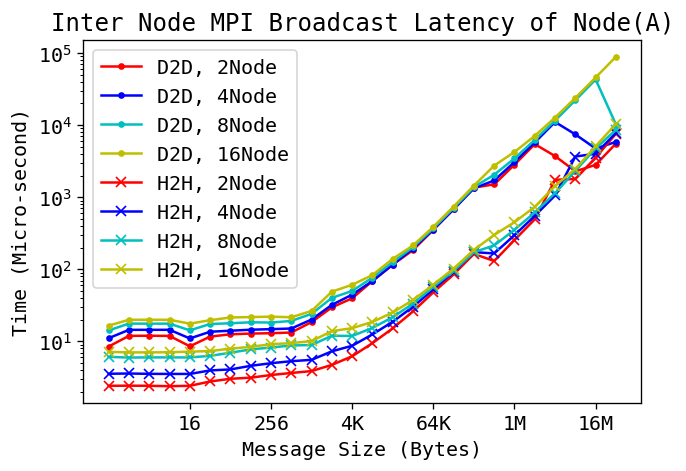

In [7]:
title = 'Inter Node MPI Broadcast Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode:2': 'D2D, 2Node',
    'mpi-gpu:anode:4': 'D2D, 4Node',
    'mpi-gpu:anode:8': 'D2D, 8Node',
    'mpi-gpu:anode:16': 'D2D, 16Node',
    'mpi-cpu:anode:2': 'H2H, 2Node',
    'mpi-cpu:anode:4': 'H2H, 4Node',
    'mpi-cpu:anode:8': 'H2H, 8Node',
    'mpi-cpu:anode:16': 'H2H, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(V)

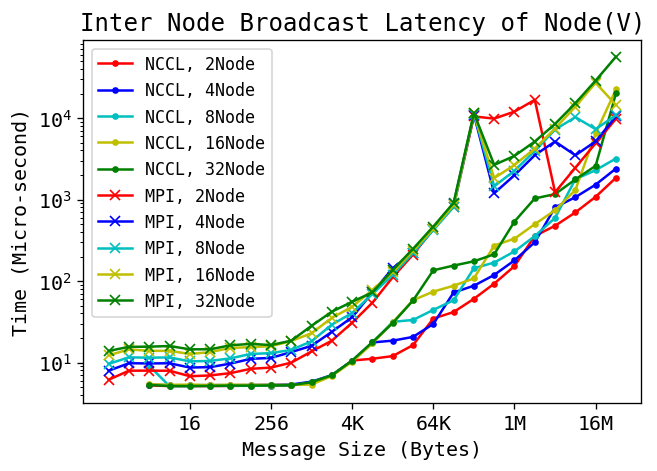

In [8]:
title = 'Inter Node Broadcast Latency of Node(V)'
column_labels = {
    'nccl:vnode:2': 'NCCL, 2Node',
    'nccl:vnode:4': 'NCCL, 4Node',
    'nccl:vnode:8': 'NCCL, 8Node',
    'nccl:vnode:16': 'NCCL, 16Node',
    'nccl:vnode:32': 'NCCL, 32Node',
    'mpi-gpu:vnode:2': 'MPI, 2Node',
    'mpi-gpu:vnode:4': 'MPI, 4Node',
    'mpi-gpu:vnode:8': 'MPI, 8Node',
    'mpi-gpu:vnode:16': 'MPI, 16Node',
    'mpi-gpu:vnode:32': 'MPI, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=10)

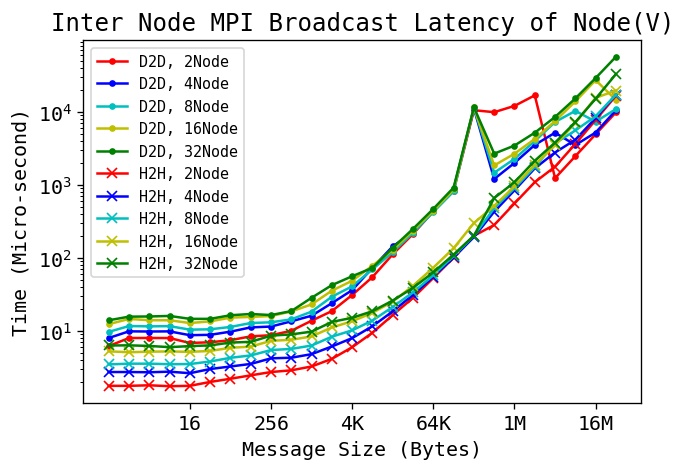

In [9]:
title = 'Inter Node MPI Broadcast Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode:2': 'D2D, 2Node',
    'mpi-gpu:vnode:4': 'D2D, 4Node',
    'mpi-gpu:vnode:8': 'D2D, 8Node',
    'mpi-gpu:vnode:16': 'D2D, 16Node',
    'mpi-gpu:vnode:32': 'D2D, 32Node',

    'mpi-cpu:vnode:2': 'H2H, 2Node',
    'mpi-cpu:vnode:4': 'H2H, 4Node',
    'mpi-cpu:vnode:8': 'H2H, 8Node',
    'mpi-cpu:vnode:16': 'H2H, 16Node',
    'mpi-cpu:vnode:32': 'H2H, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=9)